## Text classification using Neural Networks

The goal of this notebook is to learn to Machine Learning for text classification.

However keep in mind:
- Deep Learning can be better on text classification that simpler ML techniques, but only on very large datasets and well designed/tuned models.
- We won't be using the most efficient (in terms of computing) techniques, as Keras is good for prototyping but rather inefficient for training small embedding models on text.
- The following projects can replicate similar word embedding models much more efficiently: [word2vec](https://github.com/dav/word2vec) and [gensim's word2vec](https://radimrehurek.com/gensim/models/word2vec.html)   (self-supervised learning only), [fastText](https://github.com/facebookresearch/fastText) (both supervised and self-supervised learning), [Vowpal Wabbit](https://github.com/JohnLangford/vowpal_wabbit/wiki) (supervised learning).
- Plain shallow sparse TF-IDF bigrams features without any embedding and Logistic Regression or Multinomial Naive Bayes is often competitive in small to medium datasets.


### Sentipolc 2016

It is the intention of the organizers to promote the construction of a shared dataset for both Sentipolc and the Named Entity rEcognition and Linking in Italian Tweets (NEEL-IT) Evalita 2016 task. Indeed, interest in entity-liking in Twitter is gaining increasing attention, as well as aspect-based sentiment analysis. In a world where e-commerce is part of our everyday life and social media platforms are regarded as new channels for marketing and for fostering trust of potential customers, such great interest in opinion mining from Twitter isn’t surprising. In this scenario, it is crucial to be able to mine opinions about specific aspects of objects and named entities. Therefore, we believe that besides the traditional task on message-level polarity classification, in the future editions of Evalita special focus should be given to entity-based sentiment analysis.
The use of common data for the Sentipolc and NEEL-IT is a first step towards the long-term goal of enabling participants to develop end-to-end system from entity linking to entity-based sentiment analysis. http://www.di.unito.it/~tutreeb/sentipolc-evalita16/data.html

In [1]:
import numpy as np
import pandas as pd

train= pd.read_csv('sentipolc16_train.csv')
test = pd.read_csv('sentipolc16_test.csv')

In [2]:
sample_idx = 1000
print(train["text"][sample_idx])

L'abuso della parola super per i ministri del governo #Monti è il segno di quanto in Italia si fosse(sia) persa la concezione del normale 


In [3]:
target_classes = train["opos"]

target_id = train["opos"][sample_idx]
print("Class of previous message:", target_id)

Class of previous message: 0


Here are all the possible classes:

In [4]:
target_classes

0       0
1       0
2       0
3       0
4       0
       ..
7405    1
7406    1
7407    0
7408    1
7409    1
Name: opos, Length: 7410, dtype: int64

### Preprocessing text for the (supervised) CBOW model

We will implement a simple classification model in Keras. Raw text requires (sometimes a lot of) preprocessing.

The following cells uses Keras to preprocess text:
- using a tokenizer. You may use different tokenizers (from scikit-learn, NLTK, custom Python function etc.). This converts the texts into sequences of indices representing the `20000` most frequent words
- sequences have different lengths, so we pad them (add 0s at the end until the sequence is of length `1000`)
- we convert the output classes as 1-hot encodings

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer

MAX_NB_WORDS = 20000

# get the raw text data
texts_train = train["text"]
texts_test =test["text"]

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(texts_train)

sequences = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

/usr/local/lib/python3.8/dist-packages/keras/preprocessing/text.py:246: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn(


Found 21234 unique tokens.


Tokenized sequences are converted to list of token ids (with an integer code):

In [ ]:
sequences[0]

The tokenizer object stores a mapping (vocabulary) from word strings to token ids that can be inverted to reconstruct the original message (without formatting):

In [10]:
type(tokenizer.word_index), len(tokenizer.word_index)

(dict, 21234)

In [6]:
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())

In [12]:
" ".join([index_to_word[i] for i in sequences[0]])

'intanto la partita per via nazionale si complica saccomanni dice che mica tutti sono mario monti http t co xptnz4x7 via linkiesta'

Let's have a closer look at the tokenized sequences:

In [7]:
seq_lens = [len(s) for s in sequences]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))

average length: 16.0
max length: 40


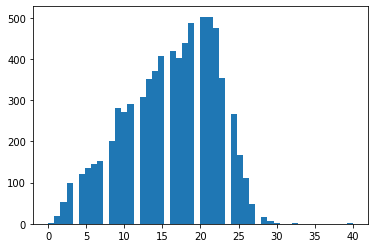

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(seq_lens, bins=50);

Let's zoom on the distribution of regular sized posts. The vast majority of the posts have less than 30 symbols:

Let's truncate and pad all the sequences to 25 symbols to build the training set:

In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_SEQUENCE_LENGTH = 25

# pad sequences with 0s
x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH,padding='post')
x_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH,padding='post')

print('Shape of data tensor:', x_train.shape)
print('Shape of data test tensor:', x_test.shape)

Shape of data tensor: (7410, 25)
Shape of data test tensor: (2000, 25)


In [9]:
x_train[0]

array([ 557,   11, 1081,   14,   47,  651,   22, 6520, 4070,  111,   10,
        904,   34,   33,   15,    1,    7,    5,    6, 6521,   47,  977,
          0,    0,    0], dtype=int32)

In [10]:
from keras.utils.np_utils import to_categorical
y_train = train["opos"]
y_test = test["opos"]

y_train = to_categorical(np.asarray(y_train))
print('Shape of label tensor:', y_train.shape)

Shape of label tensor: (7410, 2)


In [11]:
y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

##A simple ScikitLearn Model

In [19]:
import gensim.downloader as api

# Download the models (1660MB)
word2vec_model300 = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [68]:
x_train_emb = []
for sentence in x_train:
  sent_emb = [0 for k in range(300)] 
  num_tok = 0
  for tok in sentence:
    if tok != 0:
      word=list(word_index.keys())[list(word_index.values()).index(tok)]
      try:
          emb = word2vec_model300.wv[word]
          sent_emb = [x + y for x, y in zip(sent_emb, emb)]
          num_tok = num_tok +1
      except:
          pass
  if num_tok != 0:
    final_sent_emb = [x / num_tok for x in sent_emb]         
  x_train_emb.append(final_sent_emb)  

x_train_emb = np.array(x_train_emb)

<ipython-input-68-af7c387085e2>:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  emb = word2vec_model300.wv[word]


In [35]:
x_train_emb.shape

(7410, 300)

In [69]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
model = GaussianNB()

# Train the model using the training sets
model = model.fit(x_train_emb,np.array(train["opos"]))

In [65]:
x_test_emb = []
for sentence in x_test:
  sent_emb = [0 for k in range(300)] 
  num_tok = 0
  for tok in sentence:
    if tok != 0:
      word=list(word_index.keys())[list(word_index.values()).index(tok)]
      try:
          emb = word2vec_model300.wv[word]
          sent_emb = [x + y for x, y in zip(sent_emb, emb)]
          num_tok = num_tok +1
      except:
          pass
  if num_tok != 0:
    final_sent_emb = [x / num_tok for x in sent_emb]     
  else:
    final_sent_emb = sent_emb  

  x_test_emb.append(final_sent_emb)  

x_test_emb = np.array(x_test_emb)

<ipython-input-65-b3d4e5236a1a>:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  emb = word2vec_model300.wv[word]


In [67]:
x_test_emb[3]

array([-0.10583496,  0.17346191, -0.04200963,  0.10374233, -0.11962891,
        0.17735073,  0.00624738, -0.02585275,  0.06591797,  0.05543736,
       -0.14481027, -0.13745117, -0.23883929, -0.02305385, -0.08729771,
        0.2122661 ,  0.10132708,  0.24436733,  0.0561894 ,  0.03029088,
       -0.14454869, -0.08150809,  0.21833147,  0.05906459, -0.11914062,
       -0.13428824, -0.06111363,  0.19949777, -0.15171596, -0.03703526,
        0.0246582 ,  0.13567243,  0.02382551, -0.11489432, -0.10062081,
        0.01499721, -0.15104893,  0.16149902,  0.17180525, -0.06269182,
       -0.05664062, -0.09280831,  0.05502755,  0.08325195,  0.01702009,
       -0.13068499, -0.04554967,  0.00729806, -0.16492571,  0.16476004,
       -0.23479353,  0.26789202,  0.05348424,  0.21290806, -0.15265765,
        0.09912109, -0.13092913, -0.15757533, -0.00468227, -0.11165946,
       -0.18324498,  0.21424648, -0.04246303, -0.06439645,  0.03559658,
       -0.17328753, -0.11858259, -0.10718209,  0.10501535,  0.19

In [43]:
x_test_emb.shape

(2000, 300)

In [70]:
predictions = model.predict(x_test_emb)

In [71]:
predictions

array([1, 0, 0, ..., 0, 1, 0])

In [72]:
#Evaluation
from sklearn.metrics import classification_report
print(classification_report(np.array(test["opos"]),predictions,digits=5))

              precision    recall  f1-score   support

           0    0.85818   0.78944   0.82238      1648
           1    0.28306   0.38920   0.32775       352

    accuracy                        0.71900      2000
   macro avg    0.57062   0.58932   0.57506      2000
weighted avg    0.75696   0.71900   0.73532      2000



In [73]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(10)

# Train the model using the training sets
model = model.fit(x_train_emb,np.array(train["opos"]))

In [74]:
predictions = model.predict(x_test_emb)

In [75]:
#Evaluation
from sklearn.metrics import classification_report
print(classification_report(np.array(test["opos"]),predictions,digits=5))

              precision    recall  f1-score   support

           0    0.83221   0.97816   0.89930      1648
           1    0.42857   0.07670   0.13012       352

    accuracy                        0.81950      2000
   macro avg    0.63039   0.52743   0.51471      2000
weighted avg    0.76117   0.81950   0.76393      2000



In [76]:
from sklearn.svm import SVC

model = SVC()

# Train the model using the training sets
model = model.fit(x_train_emb,np.array(train["opos"]))

In [77]:
predictions = model.predict(x_test_emb)

In [78]:
#Evaluation
from sklearn.metrics import classification_report
print(classification_report(np.array(test["opos"]),predictions,digits=5))

              precision    recall  f1-score   support

           0    0.83207   0.99818   0.90759      1648
           1    0.86957   0.05682   0.10667       352

    accuracy                        0.83250      2000
   macro avg    0.85082   0.52750   0.50713      2000
weighted avg    0.83867   0.83250   0.76662      2000



### A simple supervised model in Keras

The following computes a very simple model:

<img src="https://m2dsupsdlclass.github.io/lectures-labs/slides/06_deep_nlp/images/fasttext.svg" style="width: 600px;" />

- Build an embedding layer mapping each word to a vector representation
- Compute the vector representation of all words in each sequence and average them
- Add a dense layer to output 20 classes (+ softmax)

In [79]:
from keras.layers import Dense, Input, Flatten
from keras.layers import GlobalAveragePooling1D, Embedding
from keras.models import Model

EMBEDDING_DIM = 50
N_CLASSES = 2

# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedded_sequences = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)(sequence_input)

average = GlobalAveragePooling1D()(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(average)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['acc'])

In [80]:
history=model.fit(x_train, y_train, validation_split=0.1,
          epochs=10, batch_size=128, verbose=2)

Epoch 1/10
53/53 - 14s - loss: 0.6481 - acc: 0.6907 - val_loss: 0.5568 - val_acc: 0.7989 - 14s/epoch - 272ms/step
Epoch 2/10
53/53 - 5s - loss: 0.5848 - acc: 0.7149 - val_loss: 0.5122 - val_acc: 0.7989 - 5s/epoch - 87ms/step
Epoch 3/10
53/53 - 4s - loss: 0.5534 - acc: 0.7151 - val_loss: 0.5144 - val_acc: 0.7989 - 4s/epoch - 74ms/step
Epoch 4/10
53/53 - 3s - loss: 0.5210 - acc: 0.7232 - val_loss: 0.5173 - val_acc: 0.8084 - 3s/epoch - 47ms/step
Epoch 5/10
53/53 - 2s - loss: 0.4874 - acc: 0.7506 - val_loss: 0.5115 - val_acc: 0.8084 - 2s/epoch - 41ms/step
Epoch 6/10
53/53 - 1s - loss: 0.4505 - acc: 0.7809 - val_loss: 0.5137 - val_acc: 0.7922 - 736ms/epoch - 14ms/step
Epoch 7/10
53/53 - 1s - loss: 0.4101 - acc: 0.8156 - val_loss: 0.5271 - val_acc: 0.7692 - 1s/epoch - 28ms/step
Epoch 8/10
53/53 - 1s - loss: 0.3700 - acc: 0.8519 - val_loss: 0.5137 - val_acc: 0.7719 - 1s/epoch - 24ms/step
Epoch 9/10
53/53 - 2s - loss: 0.3312 - acc: 0.8817 - val_loss: 0.5043 - val_acc: 0.7733 - 2s/epoch - 29ms/

In [81]:
output_test = model.predict(x_test)
test_casses = np.argmax(output_test, axis=-1)

63/63 [==============================] - 0s 1ms/step


In [82]:
test_casses

array([0, 0, 0, ..., 0, 0, 0])

In [83]:
from sklearn.metrics import classification_report
print(classification_report(np.array(test["opos"]),test_casses,digits=5))

              precision    recall  f1-score   support

           0    0.86512   0.94964   0.90541      1648
           1    0.56545   0.30682   0.39779       352

    accuracy                        0.83650      2000
   macro avg    0.71528   0.62823   0.65160      2000
weighted avg    0.81238   0.83650   0.81607      2000



### Building more complex models

**Exercise**
- From the previous template, build more complex models using:
  - 1d convolution and 1d maxpooling. Note that you will still need a GloabalAveragePooling or Flatten after the convolutions
  - Recurrent neural networks through LSTM (you will need to reduce sequence length before)
  
  
<img src="https://m2dsupsdlclass.github.io/lectures-labs/slides/06_deep_nlp/images/unrolled_rnn_one_output_2.svg" style="width: 600px;" />

**Bonus**
- You may try different architectures with:
  - more intermediate layers, combination of dense, conv, recurrent
  - different recurrent (GRU, RNN)
  - bidirectional LSTMs

Note: The goal is to build working models rather than getting better test accuracy. To achieve much better results, we'd need more computation time and data quantity. Build your model, and verify that they converge to OK results.

In [84]:
# solutions lstm.py
from keras.layers import LSTM, Conv1D, MaxPooling1D, Embedding, Flatten, Dense, Dropout
EMBEDDING_DIM = 300

In [85]:
# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True) (sequence_input)

# LSTM layer with a hidden size of 64
x = LSTM(64,dropout=0.2)(embedded_sequences)
x = Dense(30) (x)
predictions = Dense(2, activation='softmax')(x)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

# You will get large speedups with these models by using a GPU
# The model might take a lot of time to converge, and even more
# if you add dropout (needed to prevent overfitting)


In [86]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 25)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 25, 300)           6000000   
                                                                 
 lstm (LSTM)                 (None, 64)                93440     
                                                                 
 dense_1 (Dense)             (None, 30)                1950      
                                                                 
 dense_2 (Dense)             (None, 2)                 62        
                                                                 
Total params: 6,095,452
Trainable params: 6,095,452
Non-trainable params: 0
_________________________________________________________________


In [87]:
model.fit(x_train,y_train,epochs=4, validation_split=0.1,
          batch_size=128)

Epoch 1/4
53/53 [==============================] - 15s 162ms/step - loss: 0.5920 - acc: 0.7142 - val_loss: 0.5240 - val_acc: 0.7800
Epoch 2/4
53/53 [==============================] - 6s 106ms/step - loss: 0.3813 - acc: 0.8339 - val_loss: 0.5805 - val_acc: 0.7395
Epoch 3/4
53/53 [==============================] - 5s 88ms/step - loss: 0.1365 - acc: 0.9499 - val_loss: 0.5605 - val_acc: 0.7679
Epoch 4/4
53/53 [==============================] - 4s 71ms/step - loss: 0.0530 - acc: 0.9828 - val_loss: 0.9357 - val_acc: 0.6910


In [88]:
output_test = model.predict(x_test)
test_casses = np.argmax(output_test, axis=-1)

from sklearn.metrics import classification_report
print(classification_report(np.array(test["opos"]),test_casses,digits=5))

63/63 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0    0.87129   0.74757   0.80470      1648
           1    0.29010   0.48295   0.36247       352

    accuracy                        0.70100      2000
   macro avg    0.58069   0.61526   0.58359      2000
weighted avg    0.76900   0.70100   0.72687      2000



In [89]:
from keras.layers import Conv1D, MaxPooling1D, Flatten

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True) (sequence_input)

# A 1D convolution with 128 output channels
x = Conv1D(128, 2, activation='relu')(embedded_sequences)
# MaxPool divides the length of the sequence by 5
x = MaxPooling1D(2)(x)
# A 1D convolution with 64 output channels
x = Conv1D(64, 2, activation='relu')(x)
# MaxPool divides the length of the sequence by 5
x = MaxPooling1D(2)(x)
x = Flatten()(x)

predictions = Dense(2, activation='softmax')(x)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])


In [90]:
model.fit(x_train,y_train,epochs=4, validation_split=0.1,
          batch_size=128)

Epoch 1/4
53/53 [==============================] - 13s 137ms/step - loss: 0.5898 - acc: 0.7076 - val_loss: 0.5262 - val_acc: 0.7989
Epoch 2/4
53/53 [==============================] - 4s 66ms/step - loss: 0.4532 - acc: 0.7751 - val_loss: 0.5586 - val_acc: 0.6923
Epoch 3/4
53/53 [==============================] - 4s 77ms/step - loss: 0.1605 - acc: 0.9468 - val_loss: 0.6593 - val_acc: 0.6734
Epoch 4/4
53/53 [==============================] - 3s 48ms/step - loss: 0.0317 - acc: 0.9937 - val_loss: 0.7621 - val_acc: 0.6991


In [91]:
output_test = model.predict(x_test)
test_casses = np.argmax(output_test, axis=-1)

from sklearn.metrics import classification_report
print(classification_report(np.array(test["opos"]),test_casses,digits=5))

63/63 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0    0.86738   0.83738   0.85211      1648
           1    0.34474   0.40057   0.37057       352

    accuracy                        0.76050      2000
   macro avg    0.60606   0.61897   0.61134      2000
weighted avg    0.77540   0.76050   0.76736      2000



In [92]:
from keras.layers import LSTM, Conv1D, MaxPooling1D

# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True) (sequence_input)

# 1D convolution with 64 output channels
x = Conv1D(128, 2)(embedded_sequences)
# MaxPool divides the length of the sequence by 5
x = MaxPooling1D(2)(x)
# LSTM layer with a hidden size of 64
x = LSTM(64)(x)
x = Dense(30) (x)
predictions = Dense(2, activation='softmax')(x)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])


In [93]:
model.fit(x_train, y_train, validation_split=0.1,
          epochs=5, batch_size=128)

Epoch 1/5
53/53 [==============================] - 10s 131ms/step - loss: 0.6002 - acc: 0.7085 - val_loss: 0.5481 - val_acc: 0.7962
Epoch 2/5
53/53 [==============================] - 4s 79ms/step - loss: 0.4143 - acc: 0.8166 - val_loss: 0.6651 - val_acc: 0.6721
Epoch 3/5
53/53 [==============================] - 3s 51ms/step - loss: 0.1458 - acc: 0.9492 - val_loss: 0.5957 - val_acc: 0.7530
Epoch 4/5
53/53 [==============================] - 3s 55ms/step - loss: 0.0416 - acc: 0.9889 - val_loss: 0.9453 - val_acc: 0.7233
Epoch 5/5
53/53 [==============================] - 2s 42ms/step - loss: 0.0122 - acc: 0.9969 - val_loss: 1.1004 - val_acc: 0.7449


In [94]:
output_test = model.predict(x_test)
test_casses = np.argmax(output_test, axis=-1)

from sklearn.metrics import classification_report
print(classification_report(np.array(test["opos"]),test_casses,digits=5))


63/63 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0    0.86361   0.86833   0.86596      1648
           1    0.36735   0.35795   0.36259       352

    accuracy                        0.77850      2000
   macro avg    0.61548   0.61314   0.61428      2000
weighted avg    0.77627   0.77850   0.77737      2000



### Loading pre-trained embeddings



In [95]:
import os.path as op
import gzip
import shutil
from urllib.request import urlretrieve
# Get pretrained FastText Embeddings
URL_REPRESENTATIONS = "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.it.300.vec.gz"
ZIP_REPRESENTATIONS = "cc.it.300.vec.gz"
FILE_REPRESENTATIONS = "cc.it.300.vec"

if not op.exists(ZIP_REPRESENTATIONS):
    print('Downloading from %s to %s...' % (URL_REPRESENTATIONS, ZIP_REPRESENTATIONS))
    urlretrieve(URL_REPRESENTATIONS, './' + ZIP_REPRESENTATIONS)
    
with gzip.open(ZIP_REPRESENTATIONS, 'rb') as f_in:
    with open(FILE_REPRESENTATIONS, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [12]:
embeddings_index = {}
embeddings_vectors = []
f = open('cc.it.300.vec', 'rb')

word_idx = 0
i = 0
for line in f:
    if i != 0:
      values = line.decode('utf-8').split()
      word = values[0]
      vector = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = word_idx
      embeddings_vectors.append(vector)
      word_idx = word_idx + 1
    i = i+1
f.close()

inv_index = {v: k for k, v in embeddings_index.items()}
print("found %d different words in the file" % word_idx)

found 2000000 different words in the file


In [13]:
# Stack all embeddings in a large numpy array
embeddings = np.vstack(embeddings_vectors)

print(embeddings.shape)

(2000000, 300)


In [14]:
def get_emb(word):
    idx = embeddings_index.get(word)
    if idx is None:
        return None
    else:
        return embeddings[idx]

### Using pre-trained embeddings in our model

We want to use these pre-trained embeddings for transfer learning. This process is rather similar than transfer learning in image recognition: the features learnt on words might help us bootstrap the learning process, and increase performance if we don't have enough training data.
- We initialize embedding matrix from the model with embeddings:
 - take all words from our 20 Newgroup vocabulary (`MAX_NB_WORDS = 20000`), and look up their embedding 
 - place the Glove embedding at the corresponding index in the matrix
 - if the word is not in the vocabulary, we only place zeros in the matrix
- We may fix these embeddings or fine-tune them

In [15]:
EMBEDDING_DIM = 300

# prepare embedding matrix
nb_words_in_matrix = 0
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = get_emb(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        nb_words_in_matrix = nb_words_in_matrix + 1
        
print("added %d words in the embedding matrix" % nb_words_in_matrix)

added 13368 words in the embedding matrix


In [16]:
print(embedding_matrix.shape)

(20000, 300)


Build a layer with pre-trained embeddings:

In [19]:
from keras.layers import Embedding
pretrained_embedding_layer = Embedding(
    MAX_NB_WORDS, EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH
)

### A model with pre-trained Embeddings

Average word embeddings pre-trained with Glove / Word2Vec usually works suprisingly well. However, when averaging more than `10-15` words, the resulting vector becomes too noisy and classification performance is degraded.

In [24]:
from keras.layers import LSTM, Conv1D, MaxPooling1D, Flatten, Input, Dense
from keras.models import Model
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
emb = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH)(sequence_input)

rec = LSTM(units=128,return_sequences = True)(emb)
flat = Flatten()(rec)
dense = Dense(200,activation='sigmoid') (flat)
predictions = Dense(2, activation='softmax')(dense)

model = Model(sequence_input, predictions)

# We don't want to fine-tune embeddings
model.layers[1].trainable=False

model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['acc'])

In [ ]:
from keras.utils import plot_model
#plot_model(model)
model.summary()

In [26]:
model.fit(x_train, y_train, validation_split=0.1,
          epochs=10, batch_size=128)

# Note, on this type of task, this technique will 
# degrade results as we train much less parameters
# and we average a large number pre-trained embeddings.
# You will notice much less overfitting then!
# Using convolutions / LSTM will help
# It is also advisable to treat seperately pre-trained
# embeddings and words out of vocabulary.

Epoch 1/10
53/53 [==============================] - 10s 17ms/step - loss: 0.5981 - acc: 0.6961 - val_loss: 0.5842 - val_acc: 0.6910
Epoch 2/10
53/53 [==============================] - 0s 8ms/step - loss: 0.5244 - acc: 0.7523 - val_loss: 0.4527 - val_acc: 0.8124
Epoch 3/10
53/53 [==============================] - 0s 7ms/step - loss: 0.4959 - acc: 0.7716 - val_loss: 0.4863 - val_acc: 0.7827
Epoch 4/10
53/53 [==============================] - 0s 7ms/step - loss: 0.4757 - acc: 0.7799 - val_loss: 0.6217 - val_acc: 0.6896
Epoch 5/10
53/53 [==============================] - 0s 6ms/step - loss: 0.4570 - acc: 0.7925 - val_loss: 0.5556 - val_acc: 0.7409
Epoch 6/10
53/53 [==============================] - 0s 7ms/step - loss: 0.4368 - acc: 0.8033 - val_loss: 0.5512 - val_acc: 0.7598
Epoch 7/10
53/53 [==============================] - 0s 6ms/step - loss: 0.4184 - acc: 0.8154 - val_loss: 0.4863 - val_acc: 0.7881
Epoch 8/10
53/53 [==============================] - 0s 7ms/step - loss: 0.4127 - acc: 0.

In [27]:
output_test = model.predict(x_test)
test_casses = np.argmax(output_test, axis=-1)

from sklearn.metrics import classification_report
print(classification_report(np.array(test["opos"]),test_casses,digits=5))

63/63 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0    0.87435   0.71359   0.78583      1648
           1    0.27939   0.51989   0.36346       352

    accuracy                        0.67950      2000
   macro avg    0.57687   0.61674   0.57464      2000
weighted avg    0.76964   0.67950   0.71150      2000

